**Note:** I haven't run this particular notebook on my personal laptop so that I could leverage the Tesla V100 GPU from Google.

# Settings

In [ ]:
!pip install pycaret[models,tuners]
!pip install --upgrade joblib==1.3
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [ ]:
%pip install shap
%pip install pycaret[analysis]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [59]:
import pycaret
pycaret.__version__

'3.3.0'

## Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from pycaret.classification import ClassificationExperiment

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

## Functions

In [ ]:
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp) if (fn + tp) != 0 else 0

def auc_precision_recall(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)


def pr_auc_score(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)


def set_custom_metrics(experiment):
    # Add metrics
    experiment.add_metric('fpr', 'FPR', false_positive_rate, greater_is_better=False)
    experiment.add_metric('fnr', 'FNR', false_negative_rate, greater_is_better=False)
    experiment.add_metric(id='aucpr', name='AUC-PR', score_func=auc_precision_recall, greater_is_better=True)

    # Remove display metrics
    metrics2remove = ['mcc', 'kappa']
    for metric in metrics2remove:
        experiment.remove_metric(metric)


def compute_metrics(y_true, y_score, threshold=0.5):
    y_pred = y_score >= threshold
    result_metrics = dict(
        accuracy = metrics.accuracy_score(y_true, y_pred),
        balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred),
        recall = metrics.recall_score(y_true, y_pred),
        precision = metrics.precision_score(y_true, y_pred),
        f1 = metrics.f1_score(y_true, y_pred),
        fpr = false_positive_rate(y_true, y_pred),
        fnr = false_negative_rate(y_true, y_pred),
        pr_auc = pr_auc_score(y_true, y_pred),
        roc_auc = metrics.roc_auc_score(y_true, y_score)
    )
    return result_metrics


def compute_metrics_by_threshold(y_true, y_score, thresholds=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]):
    results = []

    for threshold in thresholds:
        result = compute_metrics(y_true, y_score, threshold=threshold)
        result['threshold'] = threshold
        results.append(result)

    df_results = (
        pd.DataFrame(results)
        .assign(
            acc_recall_avg = lambda x: x.apply(lambda row: np.mean([row['accuracy'], row['recall']]), axis=1 )
        )
        .assign(threshold = lambda x: x.threshold.astype(str))
        .set_index('threshold')
        .style
        .highlight_max(subset=['accuracy','balanced_accuracy','recall','precision','f1','pr_auc', 'acc_recall_avg'])
        .highlight_min(subset=['fpr','fnr'])
    )

    return df_results

## Configs

## Load data

In [ ]:
# Load data
df_train = pd.read_parquet('/content/drive/MyDrive/GitHub/crm_project/data/train_set.parquet')
df_customer_country = pd.read_parquet('/content/drive/MyDrive/GitHub/crm_project/data/customer_country.parquet')
df = df_train.join(df_customer_country, how='left').drop(columns=['ScoreDate'])

In [ ]:
display(df)

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2,0,2,3,3,3,2,5,4,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,4,3,2,5,3,3,5,4,3,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,4,1,2,4,7,4,1,0,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2,3,7,4,1,2,0,2,0,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,5,1,4,4,3,4,4,3,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831140,0,5,2,0,0,1,3,0,2,2,...,1690,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Germany
11118841,2,1,6,4,3,1,3,4,5,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
6332527,4,2,2,7,3,3,3,3,7,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France


# AutoML

Let's first test the models using all the features with the default PyCaret setup:

In [ ]:
# Instantiate experiment
exp = ClassificationExperiment()

# Default experiment setup
exp.setup(df, target='target', session_id=42, use_gpu=True)

# Set custom metrics
set_custom_metrics(exp)

# Compare available models
best = exp.compare_models(sort='recall', cross_validation=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(55415, 275)"
5,Transformed train set shape,"(38790, 275)"
6,Transformed test set shape,"(16625, 275)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Model,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR,TT (Sec)
nb,Naive Bayes,0.1629,0.6843,0.9078,0.0181,0.0355,0.8500,0.0922,0.4637,1.0200
qda,Quadratic Discriminant Analysis,0.2420,0.5458,0.8511,0.0188,0.0367,0.7685,0.1489,0.4362,1.7300
lda,Linear Discriminant Analysis,0.9739,0.7765,0.2624,0.2467,0.2543,0.0138,0.7376,0.2608,1.8600
dt,Decision Tree Classifier,0.9670,0.5755,0.1702,0.1326,0.1491,0.0192,0.8298,0.1584,16.1600
ada,Ada Boost Classifier,0.9829,0.8056,0.0851,0.4800,0.1446,0.0016,0.9149,0.2903,30.3500
lightgbm,Light Gradient Boosting Machine,0.9827,0.8263,0.0851,0.4444,0.1429,0.0018,0.9149,0.2725,2.3200
gbc,Gradient Boosting Classifier,0.9820,0.8449,0.0780,0.3548,0.1279,0.0024,0.9220,0.2242,162.8400
xgboost,Extreme Gradient Boosting,0.9832,0.8065,0.0674,0.5429,0.1199,0.0010,0.9326,0.3130,1.6800
catboost,CatBoost Classifier,0.9831,0.8479,0.0603,0.5152,0.1079,0.0010,0.9397,0.2957,33.1800
ridge,Ridge Classifier,0.9835,0.5281,0.0567,0.6667,0.1046,0.0005,0.9433,0.3697,1.0200


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

We can see that either the accuracy is high and the recall is low or vice versa.

Many possible reasons can explain this behavior, but the one contributing the most (probably) is the target's imbalanced nature.

Here, I want to optimize the recall while maintaining good accuracy and AUC score (so we can easily change the cutoff threshold of the trained model to achieve the business needs if necessary).

Let's now compare the models by applying some preprocessing techniques, and resampling the training data to deal with the target imbalance:

In [ ]:
# Instantiate experiment
exp = ClassificationExperiment()

# Default experiment setup
exp.setup(
    df, target='target',
    fix_imbalance=True,
    fix_imbalance_method='RandomUnderSampler',
    normalize=True,
    normalize_method='robust',
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    low_variance_threshold=0.01,
    remove_outliers=False,
    feature_selection=False,
    use_gpu=True,
    session_id=42
)

# Set custom metrics
set_custom_metrics(exp)

# Compare available models
best = exp.compare_models(sort='recall', cross_validation=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 237)"
5,Transformed train set shape,"(1318, 237)"
6,Transformed test set shape,"(16625, 237)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Model,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR,TT (Sec)
svm,SVM - Linear Kernel,0.3881,0.5912,0.8014,0.0219,0.0425,0.6190,0.1986,0.4133,8.9200
et,Extra Trees Classifier,0.7711,0.8135,0.7128,0.0512,0.0955,0.2279,0.2872,0.3844,9.0900
catboost,CatBoost Classifier,0.8075,0.8310,0.7128,0.0605,0.1116,0.1908,0.2872,0.3891,31.2400
xgboost,Extreme Gradient Boosting,0.7815,0.8206,0.7092,0.0533,0.0992,0.2173,0.2908,0.3837,9.1900
dt,Decision Tree Classifier,0.6811,0.6915,0.7021,0.0366,0.0695,0.3192,0.2979,0.3719,9.1500
lightgbm,Light Gradient Boosting Machine,0.8002,0.8301,0.6950,0.0571,0.1055,0.1980,0.3050,0.3787,9.6500
gbc,Gradient Boosting Classifier,0.8218,0.8331,0.6915,0.0635,0.1163,0.1760,0.3085,0.3801,13.3700
rf,Random Forest Classifier,0.8225,0.8293,0.6809,0.0629,0.1151,0.1751,0.3191,0.3746,9.2100
ada,Ada Boost Classifier,0.7719,0.7895,0.6702,0.0486,0.0906,0.2263,0.3298,0.3622,9.8300
lr,Logistic Regression,0.7402,0.7391,0.6489,0.0416,0.0781,0.2582,0.3511,0.3482,9.5600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Given these results, I'll proceed with the Catboost model (high AUC, Recall, and Accuracy).

Let's test the Catboost classifier using two imbalance approaches: class-weighing and random under-sample.

-> Class-weightening

In [ ]:
# Instantiate experiment
exp = ClassificationExperiment()

# Default experiment setup
exp.setup(
    df, target='target',
    fix_imbalance=False,
    normalize=True,
    normalize_method='robust',
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    low_variance_threshold=0.01,
    remove_outliers=False,
    feature_selection=False,
    use_gpu=True,
    session_id=42
)

# Set custom metrics
set_custom_metrics(exp)

# Instantiate models with custom class-weights
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, task_type='GPU', devices='0:1', silent=True)

# Compare available models
catboost_clf = exp.create_model(catboost, cross_validation=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(55415, 237)"
5,Transformed train set shape,"(38790, 237)"
6,Transformed test set shape,"(16625, 237)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8947,0.8392,0.6277,0.0971,0.1683,0.1007,0.3723,0.3656


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Create & evaluate models for distinct thresholds
target_models = {'catboost_weighted': catboost}

pycaret_models = {}
for model_name,model in target_models.items():
    print('\n\n', model_name)
    model = exp.create_model(model, cross_validation=False)
    pycaret_models[model_name] = model
    y_test_score = model.predict_proba(exp.X_test_transformed)[:,1]
    df_results = compute_metrics_by_threshold(
        exp.y_test, y_test_score,
        thresholds=[.3, .35, .4, .45, .5]
    )
    display(df_results)
    print()



 catboost_weighted


,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8914,0.8348,0.6312,0.0947,0.1647,0.1041,0.3688,0.3661


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,recall,precision,f1,fpr,fnr,pr_auc,roc_auc,acc_recall_avg
threshold,,,,,,,,,,
0.3,0.686857,0.746634,0.808511,0.042379,0.080537,0.315242,0.191489,0.427069,0.834808,0.747684
0.35,0.767519,0.747585,0.726950,0.051340,0.095906,0.231781,0.273050,0.391461,0.834808,0.747235
0.4,0.828391,0.752409,0.673759,0.064385,0.117538,0.168941,0.326241,0.371839,0.834808,0.751075
0.45,0.868692,0.764195,0.656028,0.081462,0.144928,0.127639,0.343972,0.371662,0.834808,0.762360
0.5,0.891368,0.763532,0.631206,0.094681,0.164662,0.104142,0.368794,0.366071,0.834808,0.761287


We can easily change the probability threshold to optimize target metrics :)

-> Under sampling

In [ ]:
# Instantiate experiment
exp = ClassificationExperiment()

# Default experiment setup
exp.setup(
    df, target='target',
    fix_imbalance=True,
    fix_imbalance_method='RandomUnderSampler',
    normalize=True,
    normalize_method='robust',
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    low_variance_threshold=0.01,
    remove_outliers=False,
    feature_selection=False,
    use_gpu=True,
    session_id=42
)

# Set custom metrics
set_custom_metrics(exp)

# Compare available models
best = exp.create_model('catboost', cross_validation=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 237)"
5,Transformed train set shape,"(1318, 237)"
6,Transformed test set shape,"(16625, 237)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8075,0.8310,0.7128,0.0605,0.1116,0.1908,0.2872,0.3891


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

It seems that the UnderSampling approach performed suitably better than the weighted approach (see threshold = 0.35).

Both approaches provided recall and accuracy > 0.7, with low precision. Given the nature of the data, it's hard to provide high precision while detecting the positive target cases (recall).

Since we aim to optimize our relationship with customers, I choose to optimize the recall while keeping a high accuracy and low FNR (false negative rate). Furthermore, I will also consider the AUC curve so we can easily adapt the probability threshold of the trained according to business needs.

## Feature selection through PyCaret

Using the same setup shown earlier, I'll test some small number of features to feed the model.

In [ ]:
# Set max_features to test
max_features = [10,15,20,30]
results = []

# # Model to select features
# catboost = CatBoostClassifier(auto_class_weights='Balanced', max_depth=10, random_state=42, task_type='GPU', devices='0:1', silent=True)

for i,k in enumerate(max_features, start=1):
    print(f'{i}/{len(max_features)} - k={k}')

    # Instantiate experiment
    exp = ClassificationExperiment()


    # Default experiment setup
    exp.setup(
        df, target='target',
        fix_imbalance=True,
        fix_imbalance_method='RandomUnderSampler',
        normalize=True,
        normalize_method='robust',
        remove_multicollinearity=True,
        multicollinearity_threshold=0.9,
        low_variance_threshold=0.01,
        remove_outliers=False,
        feature_selection=True,
        feature_selection_method='classic',
        feature_selection_estimator=catboost,
        n_features_to_select=k,
        use_gpu=True,
        session_id=42
    )

    # Set custom metrics
    set_custom_metrics(exp)

    # Compare available models
    catboost_clf = exp.create_model('catboost', cross_validation=False)
    df_result = exp.pull().assign(max_features=k)
    results.append(df_result)

1/4 - k=10
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becaus

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 11)"
5,Transformed train set shape,"(1318, 11)"
6,Transformed test set shape,"(16625, 11)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8095,0.8211,0.6915,0.0595,0.1096,0.1885,0.3085,0.3781


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2/4 - k=15
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becaus

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 16)"
5,Transformed train set shape,"(1318, 16)"
6,Transformed test set shape,"(16625, 16)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.7984,0.8194,0.7021,0.0571,0.1057,0.1999,0.2979,0.3822


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

3/4 - k=20
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becaus

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 21)"
5,Transformed train set shape,"(1318, 21)"
6,Transformed test set shape,"(16625, 21)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8035,0.8164,0.6738,0.0565,0.1042,0.1943,0.3262,0.3679


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

4/4 - k=30
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becaus

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 31)"
5,Transformed train set shape,"(1318, 31)"
6,Transformed test set shape,"(16625, 31)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8007,0.8239,0.7092,0.0583,0.1077,0.1977,0.2908,0.3862


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
(
    pd.concat(results)
    .set_index('max_features')
    .style
    .highlight_max(subset=['Accuracy','AUC','Recall','Prec.','F1','AUC-PR'])
    .highlight_min(subset=['FPR','FNR'])
)

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
max_features,,,,,,,,
10,0.809500,0.821100,0.691500,0.059500,0.109600,0.188500,0.308500,0.378100
15,0.798400,0.819400,0.702100,0.057100,0.105700,0.199900,0.297900,0.382200
20,0.803500,0.816400,0.673800,0.056500,0.104200,0.194300,0.326200,0.367900
30,0.800700,0.823900,0.709200,0.058300,0.107700,0.197700,0.290800,0.386200


It seems that 10 features work just fine! Given some experiments not shown here, I'll proceed with 12.

## Final model

Given the final setup, model and number of features, let's create and tune our final classifier:

### Create model

In [ ]:
# Instantiate experiment
exp = ClassificationExperiment()

# Default experiment setup
exp.setup(
    df, target='target',
    fix_imbalance=True,
    fix_imbalance_method='RandomUnderSampler',
    normalize=True,
    normalize_method='robust',
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    low_variance_threshold=0.01,
    remove_outliers=False,
    feature_selection=True,
    feature_selection_method='classic',
    feature_selection_estimator=catboost,
    n_features_to_select=12,
    use_gpu=True,
    session_id=42
)

# Set custom metrics
set_custom_metrics(exp)

# Compare available models
catboost_clf = exp.create_model('catboost', cross_validation=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(55415, 269)"
4,Transformed data shape,"(17943, 13)"
5,Transformed train set shape,"(1318, 13)"
6,Transformed test set shape,"(16625, 13)"
7,Numeric features,267
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Test,0.8081,0.8118,0.6879,0.0589,0.1084,0.1898,0.3121,0.3760


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

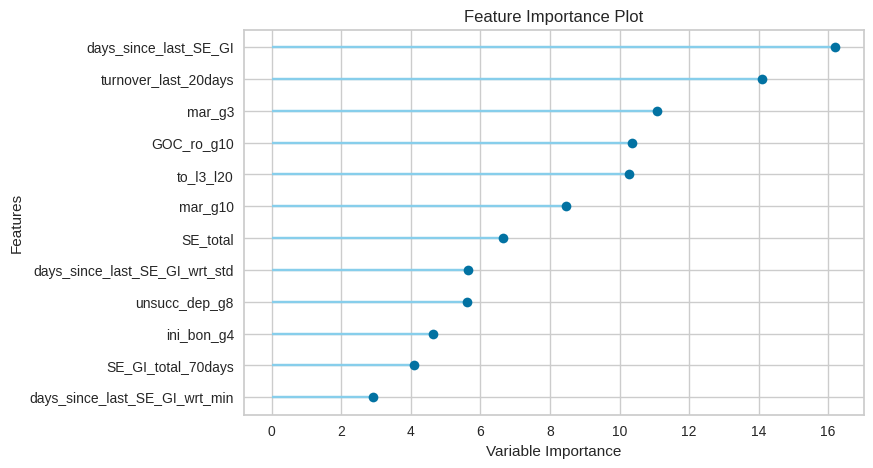

In [ ]:
# Visualizing the most important features
exp.plot_model(catboost_clf, plot='feature_all')

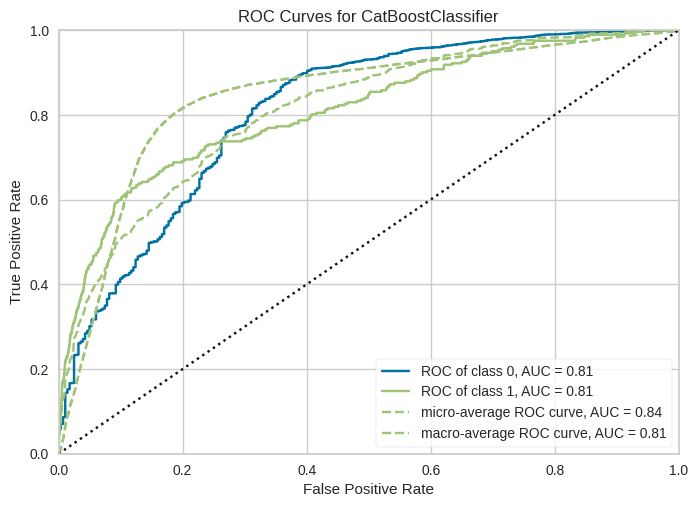

In [ ]:
# ROC curve
exp.plot_model(catboost_clf, plot='auc')

### Tune model

In [27]:
tuned_catboost_clf = exp.tune_model(catboost_clf, fold=4, n_iter=100, optimize='recall', search_library='scikit-optimize', search_algorithm='bayesian')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:20:13
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
Fold,,,,,,,,
0,0.7110,0.0000,0.7515,0.0430,0.0813,-0.0000,-0.0000,0.0000
1,0.7196,0.0000,0.7758,0.0456,0.0861,-0.0000,-0.0000,0.0000
2,0.7469,0.0000,0.7561,0.0489,0.0918,-0.0000,-0.0000,0.0000
3,0.7394,0.0000,0.7515,0.0475,0.0894,-0.0000,-0.0000,0.0000
Mean,0.7292,0.0000,0.7587,0.0462,0.0871,0.0000,0.0000,0.0000
Std,0.0145,0.0000,0.0100,0.0022,0.0039,0.0000,0.0000,0.0000


In [42]:
# Best hyperparameters
tuned_catboost_clf.get_params()

{'depth': 8,
 'l2_leaf_reg': 1,
 'border_count': 32,
 'verbose': False,
 'random_strength': 0.7645942352352573,
 'task_type': 'GPU',
 'n_estimators': 216,
 'random_state': 42,
 'eta': 0.45989583401669654}

In [38]:
# Visualize transformed data
exp.X_train_transformed

,mar_g10,mar_g3,GOC_ro_g10,unsucc_dep_g8,ini_bon_g4,turnover_last_20days,to_l3_l20,SE_total,SE_GI_total_70days,days_since_last_SE_GI,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_std
mk_CurrentCustomer,,,,,,,,,,,,
11924984,-0.353282,-1.476157,0.964097,0.000000,0.000000,0.037230,1.586392,0.0,0.0,0.000000,0.0,0.000000
8761274,-0.305031,-0.877883,0.020596,2.166667,0.056577,-0.057783,0.196956,0.5,0.0,1.987261,0.0,0.000000
10011784,1.614176,0.000000,-0.092402,0.000000,0.000000,0.431367,0.438476,3.5,0.0,2.509554,6.0,3.519483
11690087,-0.084346,0.000000,0.344559,0.000000,0.000000,0.277198,-0.282901,0.5,0.0,7.477707,0.0,0.000000
9093435,1.142510,0.000000,-0.179237,0.000000,0.000000,-0.087599,0.334229,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
13024159,0.691790,1.103156,1.474534,0.000000,37.567187,0.477204,0.097085,0.0,0.0,0.000000,0.0,0.000000
7905625,-0.416495,-0.367907,2.606179,0.000000,18.217822,0.053693,0.309161,0.0,0.0,0.000000,0.0,0.000000
10364770,0.339069,0.000000,-0.202060,91.000000,4.370580,2.441147,-0.282901,0.0,0.0,0.000000,0.0,0.000000


In [40]:
# Best 12 features
exp.X_train_transformed.columns.tolist()

['mar_g10',
 'mar_g3',
 'GOC_ro_g10',
 'unsucc_dep_g8',
 'ini_bon_g4',
 'turnover_last_20days',
 'to_l3_l20',
 'SE_total',
 'SE_GI_total_70days',
 'days_since_last_SE_GI',
 'days_since_last_SE_GI_wrt_min',
 'days_since_last_SE_GI_wrt_std']

In [43]:
# Compute metrics
y_test_scores = exp.predict_model(tuned_catboost_clf, raw_score=True)['prediction_score_1']
compute_metrics(exp.y_test, y_test_scores, threshold=0.5)

,Model,Accuracy,AUC,Recall,Prec.,F1,FPR,FNR,AUC-PR
0,CatBoost Classifier,0.7235,0.8004,0.7411,0.0442,0.0834,0.2768,0.2589,0.3948


{'accuracy': 0.7235488721804512,
 'balanced_accuracy': 0.7321900889746971,
 'recall': 0.7411347517730497,
 'precision': 0.044167371090448014,
 'f1': 0.08336657359393698,
 'fpr': 0.27675457382365537,
 'fnr': 0.25886524822695034,
 'pr_auc': 0.3948465501535533,
 'roc_auc': 0.8004110029539617}

In [39]:
# Evaluate model
exp.evaluate_model(tuned_catboost_clf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# Interpret model
exp.interpret_model(tuned_catboost_clf)

## Finalize & Save model

In [57]:
exp.save_model(model=tuned_catboost_clf, model_name='pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['days_g10', 'days_g9', 'days_g8',
                                              'days_g7', 'days_g6', 'days_g5',
                                              'days_g4', 'days_g3', 'days_g2',
                                              'days_g1', 'ro_g10', 'ro_g9',
                                              'ro_g8', 'ro_g7', 'ro_g6', 'ro_g5',
                                              'ro_g4', 'ro_g3', 'ro_g2', 'ro_g1',
                                              'to_g10', 'to_g9', 'to_g8',
                                              'to_g7', 'to_g6', 'to_g5', 'to_g4',
                                              'to_...
                                                              with_scaling=True))),
                 ('feature_selection',
                  TransformerWrapper(exclude=[], include=No

In [58]:
exp.save_model(model=tuned_catboost_clf, model_name='/content/drive/MyDrive/GitHub/crm_project/models/pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['days_g10', 'days_g9', 'days_g8',
                                              'days_g7', 'days_g6', 'days_g5',
                                              'days_g4', 'days_g3', 'days_g2',
                                              'days_g1', 'ro_g10', 'ro_g9',
                                              'ro_g8', 'ro_g7', 'ro_g6', 'ro_g5',
                                              'ro_g4', 'ro_g3', 'ro_g2', 'ro_g1',
                                              'to_g10', 'to_g9', 'to_g8',
                                              'to_g7', 'to_g6', 'to_g5', 'to_g4',
                                              'to_...
                                                              with_scaling=True))),
                 ('feature_selection',
                  TransformerWrapper(exclude=[], include=No